In [1]:
# Important necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division
from matplotlib.lines import Line2D
from tqdm import *
from itertools import compress
from scipy.optimize import bisect
%matplotlib inline  

In [2]:
def combine_background_files(folder='../data/bkg_Zj/', lumi=37*1000, nfiles=200, cut=None):
    """ Read .evt and .meta files as output by monojet.C and 
        properly weigh events
    """
    
    evt_frames = [pd.read_csv(folder+'events_'+str(i)+'.evt', header=0, delimiter=',', skipinitialspace=True) for i in range(nfiles)]
    good_frames = np.array([len(evt_frame) for evt_frame in evt_frames]) > 0
    
    evt_frames = list(compress(evt_frames, good_frames))
    meta_frames = [pd.read_csv(folder+'events_'+str(i)+'.meta', header=0, delimiter=',', skipinitialspace=True) for i in compress(range(nfiles),good_frames)]
    sum_weights = np.sum([meta_frame['sum_weight'] for meta_frame in meta_frames])
    for evt_frame, meta_frame in zip(evt_frames, meta_frames):
        evt_frame['weight'] *= (meta_frame['cxn']*lumi/sum_weights)[0]*5000
        
    data = pd.concat(evt_frames)
    
    if cut is not None:
        data = data.query(cut)
    return data

In [20]:
def to_str(num):
    if .2 <= num <= .9:
        return '{:0.1g}'.format(num)[-2:]
    elif num == 0:
        return '0.0'
    elif num == 0.99:
        return '0.99'
    elif num == 1:
        return '1.0'
    else:
        return str(num)

print( to_str(0.5))
    
def combine_signal_files(folder='../data/bkg_Zj/', mphi = 1700, rinv = 1, lumi=37*1000, nfiles=4, cut = None,extra='', return_cxn = False):
    """ Read .evt and .meta files as output by monojet.C and 
        properly weigh events
    """
    
    evt_frames = [pd.read_csv(folder+'events_'+str(extra)+str(mphi)+"_"+to_str(rinv)+"_"+str(i)+'.evt', header=0, delimiter=',', skipinitialspace=True) for i in range(nfiles)]
    good_frames = np.array([len(evt_frame) for evt_frame in evt_frames]) > 0
    
    evt_frames = list(compress(evt_frames, good_frames))
    meta_frames = [pd.read_csv(folder+'events_'+str(mphi)+"_"+to_str(rinv)+"_"+str(i)+'.meta', header=0, delimiter=',', skipinitialspace=True) for i in compress(range(nfiles),good_frames)]
    sum_weights = np.sum([meta_frame['sum_weight'] for meta_frame in meta_frames])
    mean_cxn  = np.mean([meta_frame['cxn'] for meta_frame in meta_frames])
    for evt_frame, meta_frame in zip(evt_frames, meta_frames):
        evt_frame['weight'] *= (meta_frame['cxn']*lumi/sum_weights)[0]
    data = pd.concat(evt_frames)
    data['cxn'] = mean_cxn
    if cut is not None:
        data = data.query(cut)
    if return_cxn:
        return data, mean_cxn
    else:
        return data

.5


# Backgrounds

In [4]:
Zj_df = combine_background_files('../data/bkg_Zj/', nfiles=200)
Wj_df = combine_background_files('../data/bkg_Wj/', nfiles=200)
tt_d_df = combine_background_files('../data/bkg_ttbar_dilep//', nfiles=200)
tt_s_df = combine_background_files('../data/bkg_ttbar_semilep//', nfiles=200)
QCD_df = combine_background_files('../data/bkg_qcd//', nfiles=600)

tt_df = pd.concat([tt_d_df, tt_s_df])

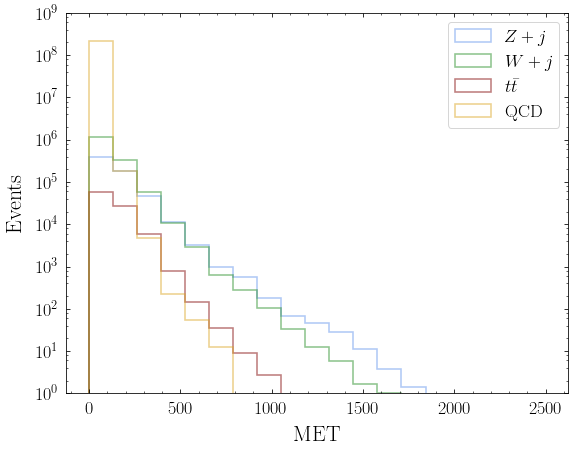

In [5]:
bins = np.linspace(0,2500,20)
normed = False

fig=plt.figure(figsize=(9,7))

plt.hist(Zj_df['MEt'], weights=Zj_df['weight'], 
                     bins=bins,
                     histtype='step', alpha=.5, lw=1.6, label="$Z+j$", normed=normed)

plt.hist(Wj_df['MEt'], weights=Wj_df['weight'], 
                     bins=bins,
                     histtype='step', alpha=.5, lw=1.6, label="$W+j$", normed=normed)

plt.hist(tt_df['MEt'], weights=tt_df['weight'], 
                     bins=bins,
                     histtype='step', alpha=.5, lw=1.6, label="$t\\bar t$", normed=normed)

plt.hist(QCD_df['MEt'], weights=QCD_df['weight'], 
                     bins=bins,
                     histtype='step', alpha=.5, lw=1.6, label="QCD", normed=normed)

plt.xlabel("MET")

plt.ylim(1e0,1e9)
plt.legend()
plt.ylabel("Events")
plt.yscale("log")

## Show background vs from ATLAS

(array([  1.04384552e+02,   1.73705184e+03,   1.43257240e+03,
          4.80678594e+03,   1.12929364e+04,   1.06777954e+05,
          3.22123326e+05,   5.07489434e+05,   7.48588670e+05,
          9.20978128e+05,   6.88447015e+05,   4.73359584e+05,
          2.72916804e+05,   1.82926471e+05,   1.42723101e+05,
          8.98429438e+04,   7.19113434e+04,   5.16290405e+04,
          4.52334437e+04,   3.29206072e+04,   2.15041906e+04,
          1.74861201e+04,   1.11870578e+04,   8.41661586e+03,
          6.67717525e+03,   6.92084809e+03,   4.11079009e+03,
          4.23952005e+03,   3.00013668e+03,   1.88032992e+03,
          2.60454409e+03,   1.34341093e+03,   1.05716723e+03,
          8.27491129e+02,   7.79438840e+02,   4.34054676e+02,
          5.60607572e+02,   3.24274373e+02,   2.92880396e+02,
          2.41541914e+02,   2.07194549e+02,   2.70292067e+02,
          1.23976183e+02,   1.15282200e+02,   1.10315205e+02,
          1.34957161e+02,   4.83843309e+01,   2.47388683e+02,
        

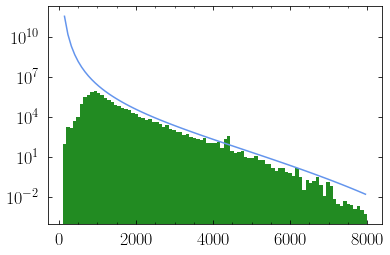

In [10]:
bkg_all = pd.concat([Zj_df, Wj_df, tt_df, QCD_df])

def qcd(x):
    bw=1.0/((8000.-100.)/90.)
    z=x/13000.
    return bw*10**(2.81271 - 1.06475*np.log(z) + 0.199172* (np.log(z))**2 + 5.46329*np.log(1 - z))
    

from math import *
bins=np.linspace(100,8000,90)
bc=(bins[:-1]+bins[1:])/2.
bw=(bins[1:]-bins[:-1])

plt.plot(bc,bw*qcd(bc))
plt.yscale('log')

bkg_cut = bkg_all.query('1.2 > y1-y2 > -1.2 & pt1 > 440 & pt2 > 60')
plt.hist(bkg_cut['mjj'],weights=bkg_cut['weight'],bins=bins)

# Signal

In [7]:
rinvs = [.01, .3, .6, 1.0 ]
sig10 = [ combine_signal_files('../data/sig_zprime/', 100000, rinv) for rinv in rinvs  ]
cxn10 = [ combine_signal_files('../data/sig_zprime/', 100000, rinv ,return_cxn=True)[1] for rinv in rinvs ]

title = "$(\\bar q \gamma^\mu q)(\\bar \chi \gamma_\mu \chi)$"
plot_color=['forestgreen','cornflowerblue', 'maroon','goldenrod','violet','maroon','darkgrey','lightpink','black','forestgreen','cornflowerblue', 'salmon','violet','goldenrod','maroon','darkgrey','lightpink']

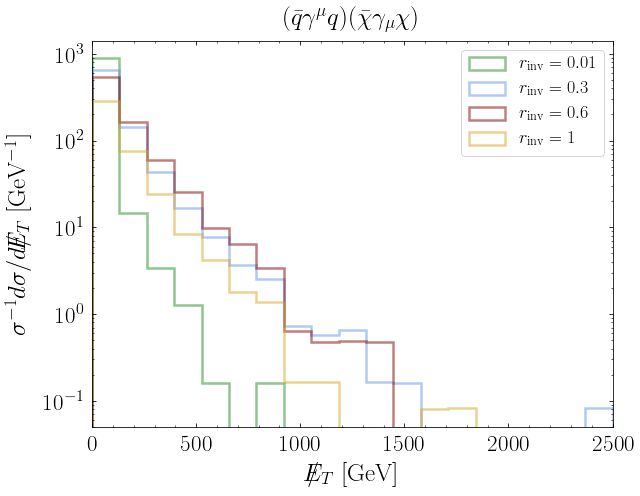

In [8]:
lumi = 37
bins = bins=np.linspace(0,2500,20)
fig=plt.figure(figsize=(9,7))

for irinv, rinv in enumerate(rinvs):
    plt.hist(sig10[irinv]['MEt'], weights=sig10[irinv]['weight'].values/cxn10[irinv]/lumi, lw=2.5, ls = 'solid', label="$r_{\\rm inv}=%0.2g$" % rinv, histtype='step', color=plot_color[irinv],alpha=.5, bins=bins)


    
plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\slash \!\!\!\! E_{T}$ [GeV]',fontsize=25)
plt.ylabel(r'${\sigma^{-1}d\sigma/d\slash \!\!\!\! E_{T}}$ [GeV$^{-1}$]',fontsize=25)  
plt.xlim([0,2500])


plt.title(title, fontsize=25)
ax = plt.gca()
ttl = ax.title
ttl.set_position([.5, 1.02])

plt.legend()
plt.tick_params(axis='both', which='major', labelsize=23)
plt.tight_layout()

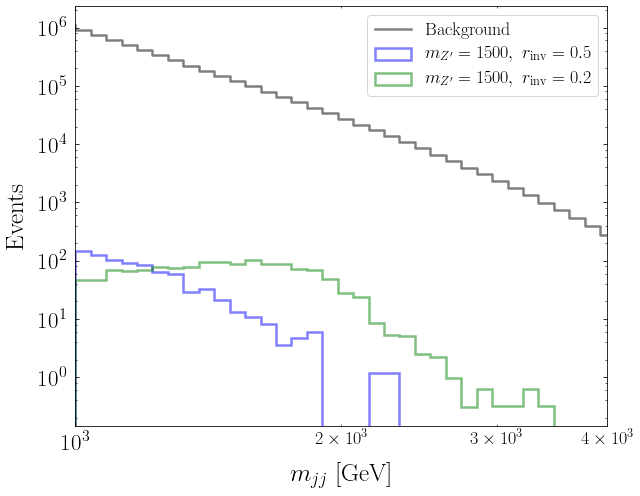

In [14]:
def qcd(x):
    z=x/13000.
    bw=1.0/((8000.-100.)/90.)
    return bw*10**(2.81271 - 1.06475*np.log(z) + 0.199172* (np.log(z))**2 + 5.46329*np.log(1 - z))

from math import *
bins=10**np.linspace(log10(100),log10(8000),91)

def get_sig(mass, rinv, cut='1.2 > y1-y2 > -1.2 & pt1 > 440 & pt2 > 60'):
    d = combine_signal_files('../data/sig_zprime/', mass, rinv)
    d = d.query(cut)
    sig, _ = np.histogram(d['mjj'],weights=d['weight'],bins=bins)
    return sig

def get_data(mass, rinv, cut='1.2 > y1-y2 > -1.2 & pt1 > 440 & pt2 > 60'):
    d = combine_signal_files('../data/sig_zprime/', mass, rinv)
    d = d.query(cut)
    return d

cut='1.2 > y1-y2 > -1.2 & pt1 > 440 & pt2 > 60'

mZ_1500 = get_data(1500,0.5).query(cut)
mZ_2000 = get_data(2000,0.2).query(cut)

bkg_cut = bkg_all.query(cut)


bins = bins=10**np.linspace(log10(1000),log10(5000),40+1)
bc=(bins[1:]+bins[:-1])/2.
bw=(bins[1:]-bins[:-1])
fig=plt.figure(figsize=(9,7))

# plot the smoothed distribution
plt.step(bins[:-1],bw*qcd(bc),
         lw=2.5, ls = 'solid', label=r"${\rm Background}$", 
         color='black',alpha=.5)

# plt.hist(bkg_cut['mjj'], weights=bkg_cut['weight'],
#          lw=2.5, ls = 'solid', label=r"${\rm Background}$", histtype='step',
#          color='black',alpha=.5, bins=bins)


plt.hist(mZ_1500['mjj'], weights=mZ_1500['weight'],
         lw=2.5, ls = 'solid', label="$m_{Z^\prime}=1500,\; r_{\\rm inv}=0.5$", histtype='step',
         color='blue',alpha=.5, bins=bins)

plt.hist(mZ_2000['mjj'], weights=mZ_2000['weight'],
         lw=2.5, ls = 'solid', label="$m_{Z^\prime}=1500,\; r_{\\rm inv}=0.2$", histtype='step',
         color='green',alpha=.5, bins=bins)


plt.yscale('log', nonposy='clip')
plt.xlabel(r'$m_{jj}$ [GeV]',fontsize=25)
plt.ylabel(r'${\rm Events}$',fontsize=25)  

plt.xlim([1000,4000])
plt.yscale('log')
plt.xscale('log')

plt.legend()
plt.tick_params(axis='both', which='major', labelsize=23)
plt.tight_layout()
#plt.xscale('log')


In [16]:
from scipy.optimize import bisect
def limit(sig,bkg):
    if np.sum(sig)==0:
        return 1e99
    def func_root(x):
        part1 = bkg > 20
        part2 = np.logical_not(part1)
        qcd_1 = bkg[part1]
        qcd_2 = bkg[part2]
        sig_1 = sig[part1]
        sig_2 = sig[part2]

        sig_t1 = (10**x)*sig_1
        sig_t2 = (10**x)*sig_2
        
        sb1 = qcd_1 + sig_1
        sb2 = qcd_2 + sig_2
        
        normpart = sig_t1**2/(2*(sb1+0.00000**2*qcd_1**2))
        logpart = np.where(qcd_2 > 1e-3, -qcd_2*np.log(1+sig_t2/qcd_2), 0)
        my_val = np.sum(normpart)+(np.sum(logpart)+np.sum(sig_t2)) - 2
        return my_val
    
    
    soln = bisect(func_root, -10.,10.)
    return 10**soln

In [22]:
rinv=np.array([0,.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,.99,1])
masses=np.arange(1000,4001,100)

bins=10**np.linspace(log10(100),log10(8000),91)
bc=(bins[:-1]+bins[1:])/2.
bw=(bins[1:]-bins[:-1])
bkg=qcd(bc)*bw


result=np.zeros([len(rinv),len(masses)])
cxn=np.zeros([len(rinv),len(masses)])

for ir,r in enumerate(rinv):
    for im,m in enumerate(masses):
        sig=get_sig(m, r)
        d=get_data(m,r)
        result[ir,im]=limit(sig,bkg)
        cxn[ir,im]=np.array(d['cxn'])[0]
        print("{:1.2f}, {:d}, {:1.5f}".format(r,m,result[ir,im]))


0.00, 1000, 0.34298
0.00, 1100, 0.34316
0.00, 1200, 0.36979
0.00, 1300, 0.41490
0.00, 1400, 0.49723
0.00, 1500, 0.57040
0.00, 1600, 0.64231
0.00, 1700, 0.73421
0.00, 1800, 0.81819
0.00, 1900, 0.93972
0.00, 2000, 1.10887
0.00, 2100, 1.24873
0.00, 2200, 1.40277
0.00, 2300, 1.55944
0.00, 2400, 1.77432
0.00, 2500, 1.95586
0.00, 2600, 2.22152
0.00, 2700, 2.41079
0.00, 2800, 2.67100
0.00, 2900, 3.08587
0.00, 3000, 3.41277
0.00, 3100, 3.71982
0.00, 3200, 4.27102
0.00, 3300, 4.87311
0.00, 3400, 5.46731
0.00, 3500, 6.04021
0.00, 3600, 6.44752
0.00, 3700, 7.07582
0.00, 3800, 7.99623
0.00, 3900, 9.05260
0.00, 4000, 10.18188
0.01, 1000, 0.36050
0.01, 1100, 0.35482
0.01, 1200, 0.39075
0.01, 1300, 0.43641
0.01, 1400, 0.51422
0.01, 1500, 0.58872
0.01, 1600, 0.66647
0.01, 1700, 0.75217
0.01, 1800, 0.85027
0.01, 1900, 0.98816
0.01, 2000, 1.11299
0.01, 2100, 1.31161
0.01, 2200, 1.47115
0.01, 2300, 1.62435
0.01, 2400, 1.88604
0.01, 2500, 2.07248
0.01, 2600, 2.27295
0.01, 2700, 2.55298
0.01, 2800, 2.84210

[  1.48079573   1.24207589   1.30220257   1.28655854   1.52462641
   1.64749618   1.93592313   2.26314537   2.56556542   2.87995667
   3.34955928   3.83430032   4.31500573   4.75599092   5.75033406
   6.37551934   7.20393606   7.96813032   9.03143664  10.71290911
  11.37877731  13.60345051  14.83448151  17.05181883  19.51066797
  21.37891355  22.87975053  27.34163071  30.40204643  35.11040434
  40.11199169]
[ 2.69202     1.8163125   1.2616925   0.88802175  0.65396475  0.480441
  0.356141    0.26882725  0.20644075  0.15984325  0.12500325  0.09795582
  0.07778043  0.0624123   0.0501993   0.0407036   0.03302672  0.0274794
  0.0223609   0.0186452   0.0155334   0.01295995  0.0109862   0.00930315
  0.00791091  0.00671846  0.00573124  0.00490698  0.00424898  0.00370867
  0.00322943]
[ 0.91717632  0.61706362  0.46679191  0.36953898  0.32240986  0.26982623
  0.22844323  0.19783447  0.17063068  0.1498608   0.1374028   0.12254047
  0.10766884  0.09746458  0.08906787  0.0794822   0.07430999  0.065

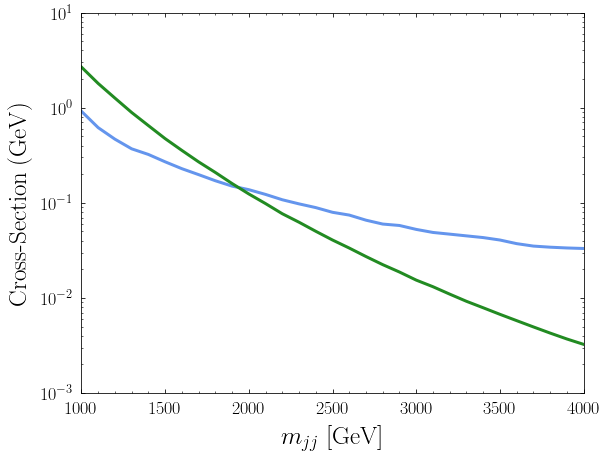

In [28]:
print(result[4])
print(cxn[4])

fig=plt.figure(figsize=(9,7))
plt.yscale('log', nonposy='clip')
plt.xlabel(r'$m_{jj}$ [GeV]',fontsize=25)
plt.ylabel(r'$\textrm{Cross-Section}\; ({\rm GeV})$',fontsize=25)  

plt.plot(masses, cxn[0]*result[0], lw=3)
plt.plot(masses, cxn[0], lw=3)


plt.xlim([1000,4000])
plt.ylim([1e-3,10])
plt.yscale('log')

print(cxn[0]*result[0])



[ 0.    0.01  0.1   0.2   0.3   0.4   0.5   0.6   0.7   0.8   0.9   0.99
  1.  ]
[ 1935.63677909  1909.48574306  1660.40287658  1395.13922946   675.31258973
  1200.17931327 -1347.88686037  -505.97158031  -760.98454629  -131.57140301
   -54.8534999     15.75510149  1600.00863795]
[ 1935.63677909  1909.48574306  1660.40287658  1395.13922946   675.31258973
     0.             0.             0.             0.             0.             0.
     0.             0.        ]
[ 1935.63677909  1909.48574306  1660.40287658  1395.13922946   675.31258973
     0.             0.             0.             0.             0.             0.
     0.             0.        ]


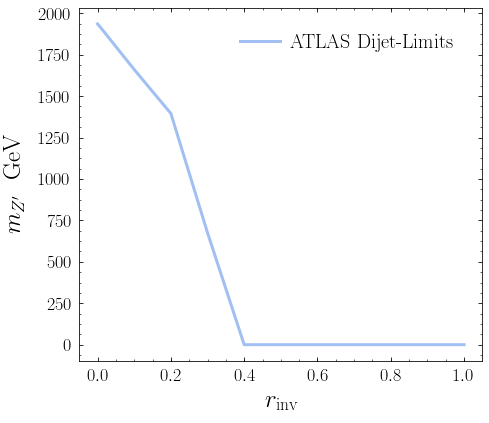

In [23]:
from scipy.optimize import fsolve

mass_limit=np.zeros(len(rinv))
for i,r in enumerate(rinv):
    mymass = np.insert(masses,0,0)
    masslist = np.insert(result[i],0,0)    
    mass_limit[i] = fsolve(lambda mZ: 1-np.interp(mZ, mymass, masslist), 3000)[0]

final_limit=mass_limit
print(rinv)
print(final_limit)
final_limit[5:]=0
print(mass_limit)


plt.figure()

fig=plt.figure("m", figsize=(8,7))
plt.subplots_adjust(left=0.2, right=0.90, top=0.9, bottom=0.2)


plt.xlabel(r'$ r_{\rm inv}$', fontsize=25)
plt.ylabel(r'$ m_{Z^\prime}\,\,{\rm\; GeV}$', fontsize=25)
plt.plot(rinv,final_limit,lw=3,alpha=.6, label=r'$\textrm{ATLAS Dijet-Limits}$')

plt.legend(bbox_to_anchor=(0, 0, .95, 0.95),
           fontsize=20, ncol=1,frameon=False,
           handletextpad=.5, columnspacing=.8,
           borderaxespad=0.)


print(final_limit)
plt.savefig("tim_zprime_dijets.pdf")

plt.show()

In [ ]:
test